# Predicting Term Deposit Subscription in Portuguese Bank Marketing Campaigns

## Introduction

### Problem statement
The objective of this project is to predict whether a client of a Portuguese bank will subscribe to a term deposit following a direct marketing campaign, based on client attributes, call history, and macroeconomic indicators. Formally, given features $X \in \mathbb{R}^p$ and a binary outcome Y in \{0,1\} indicating subscription (`y = "yes"` → 1), the task is to approximate the conditional probability $P(Y = 1 \mid X = x)$ and construct a classification rule $\hat{y} = \mathbb{1}\{f(x) \ge \tau\}$.

### Motivation and challenges
Direct marketing campaigns are costly because each customer contact consumes call center resources and potentially harms customer satisfaction. Only a small fraction of contacted customers subscribe, making the data highly imbalanced and naive strategies (e.g., calling everyone) inefficient. The modeling challenge is to learn a classifier that prioritizes high‑value customers, handles nonlinear interactions between client and campaign features, and remains robust to class imbalance.

### Approach overview
This project uses the UCI Bank Marketing dataset with over 40,000 campaign records and 17–20 predictive features, including demographic attributes (age, job, marital status, education), campaign history (number of contacts, previous outcomes), and call characteristics (month, day, duration). The pipeline includes: 

- (1) exploratory data analysis and visualization, 
- (2) preprocessing of mixed‑type data, 
- (3) model training and tuning with logistic regression and random forest, 
- (4) threshold and error analysis under class imbalance,
- (5) interpretation via coefficients and feature importance. Logistic regression provides a probabilistic, interpretable linear model, while random forest offers a flexible nonparametric baseline that captures nonlinear relationships and interactions.

## Data
### Load and inspect the UCI Bank Marketing dataset.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  roc_auc_score,
  confusion_matrix,
  RocCurveDisplay,
  classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid", context="notebook")

data_path = r"C:\Users\kotha\Downloads\machine-learning-final-project\data\bank-full.csv"
df = pd.read_csv(data_path, sep=';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Basic structure and missingness

In [36]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Target distribution and imbalance

y
no     39922
yes     5289
Name: count, dtype: int64
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


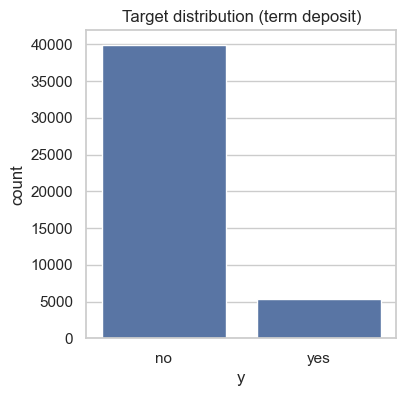

In [37]:
print(df["y"].value_counts())
print(df["y"].value_counts(normalize=True))

plt.figure(figsize=(4,4))
sns.countplot(data=df, x="y")
plt.title("Target distribution (term deposit)")
plt.show()

This output shows that the majority of clients did not subscribe to a term deposit (y = "no"), confirming that the dataset is class‑imbalanced. This imbalance motivates using metrics like F1 and ROC–AUC instead of accuracy alone and justifies later threshold tuning and model choices that focus on the minority positive class.

## Feature description and EDA
According to UCI, a typical bank-full.csv has 16 input attributes + target.

### Identify numeric and categorical features

In [38]:
df.columns

numeric_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_features = [c for c in df.columns if c not in numeric_features + ["y"]]

numeric_features, categorical_features


(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome'])

### Univariate distributions (numeric)

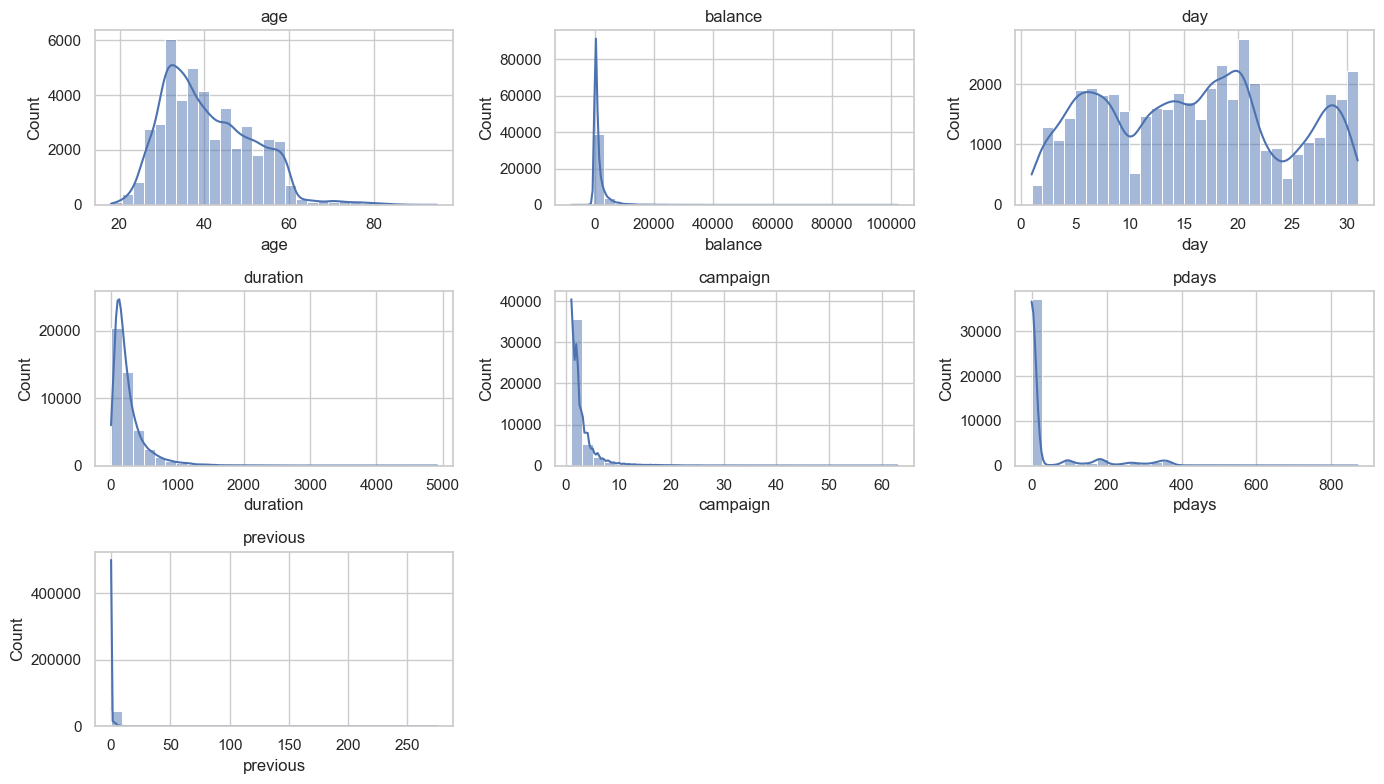

In [12]:
plt.figure(figsize=(14,8))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

These histograms show how each numeric feature is distributed (e.g., skewed balances, call durations, and contact counts), revealing outliers and non‑Gaussian shapes. This supports the decision to standardize numeric variables and alerts us that some features (like balance or duration) may dominate model behavior if not scaled.

### Univariate distributions (categorical)

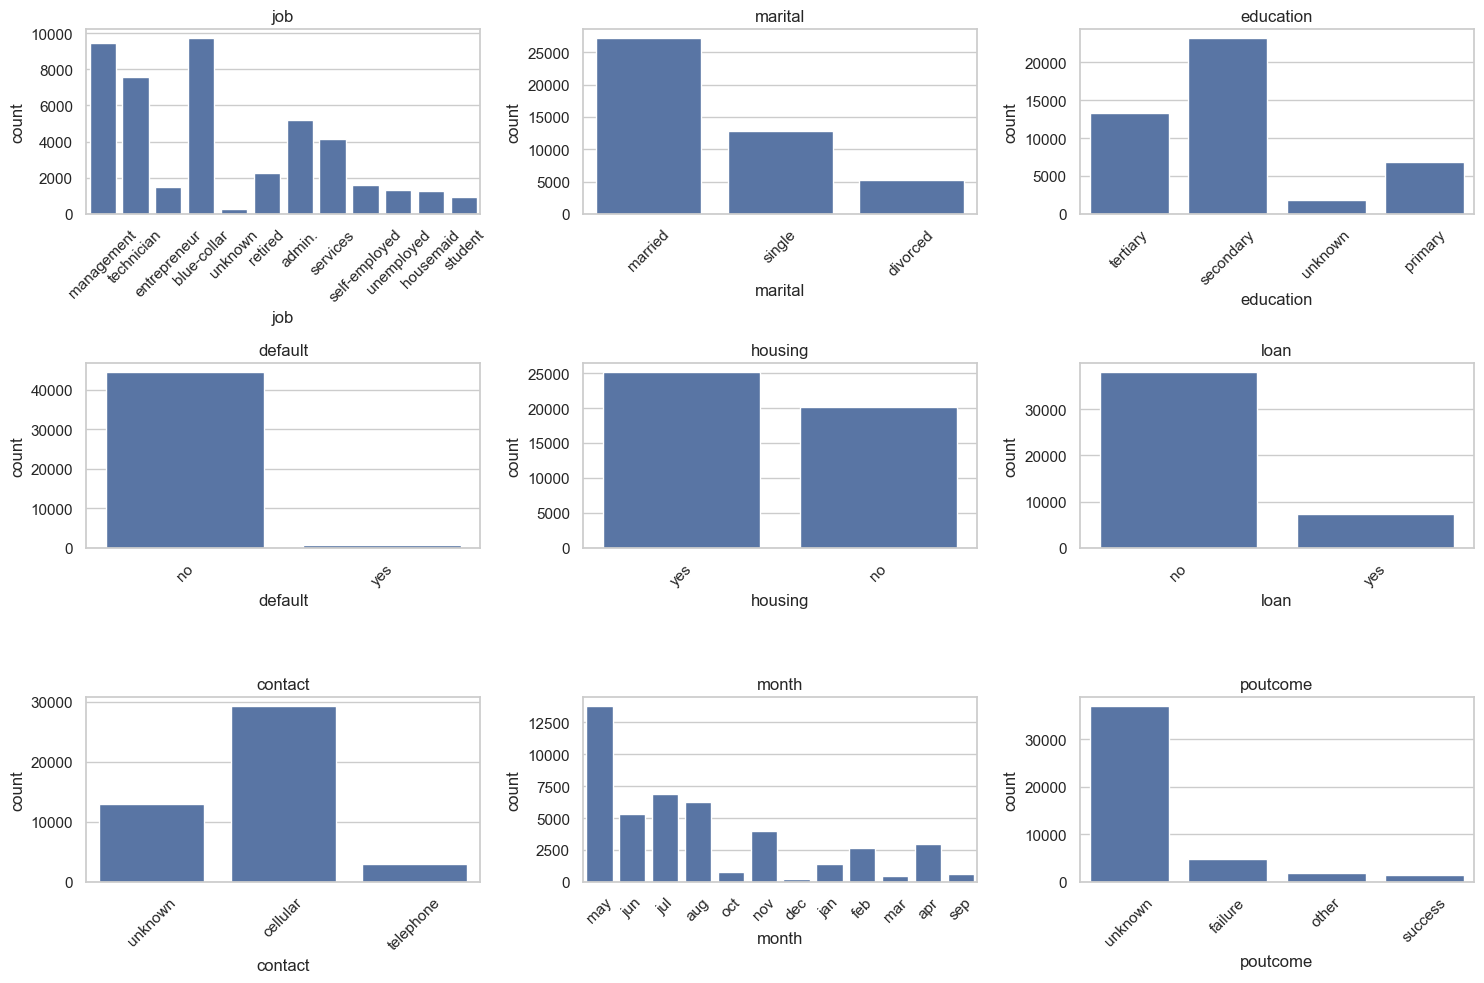

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
axes = axes.flatten()

for ax, col in zip(axes, categorical_features):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

The categorical count plots show how clients are distributed across jobs, marital status, education, contact types, months, and previous outcomes. This helps identify dominant categories and rare levels, which is important for one‑hot encoding and for interpreting later model coefficients and feature importances.

### Numeric features vs target

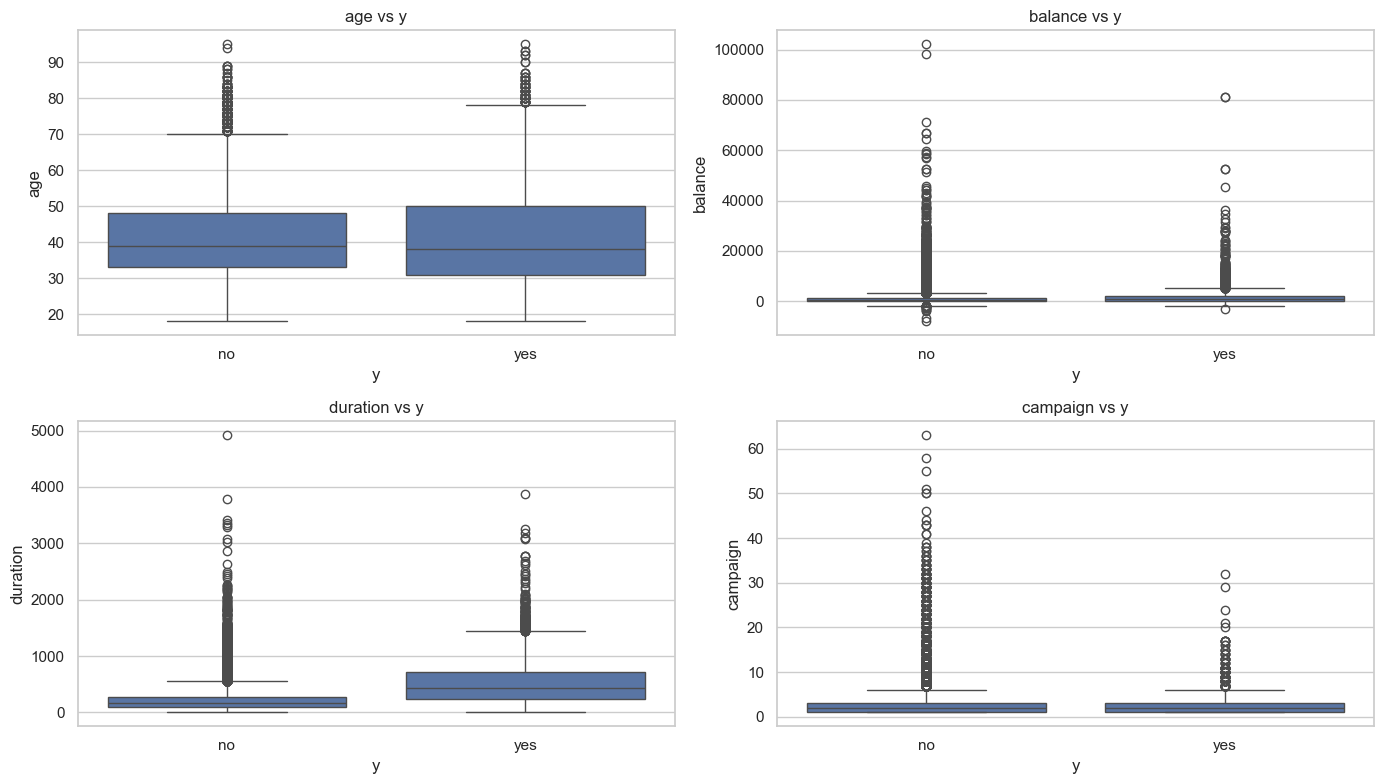

In [14]:
plt.figure(figsize=(14,8))
for i, col in enumerate(["age", "balance", "duration", "campaign"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="y", y=col)
    plt.title(f"{col} vs y")
plt.tight_layout()
plt.show()

These boxplots compare the distributions of key numeric features between subscribers and non‑subscribers, showing, for example, that longer call durations and different campaign contact counts are associated with higher subscription rates. This visually supports the idea that these variables will be important predictors in the models.

### Categorical features vs target (conditional proportions)

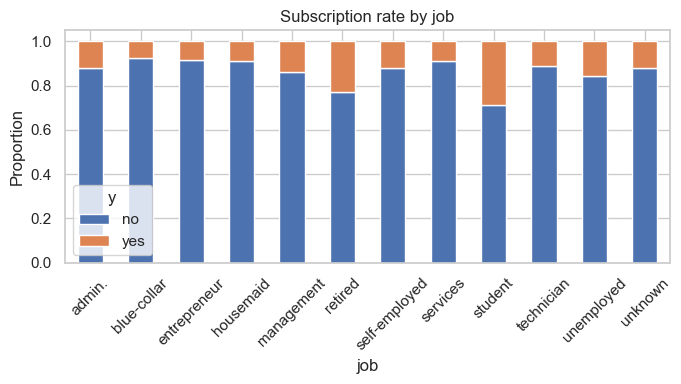

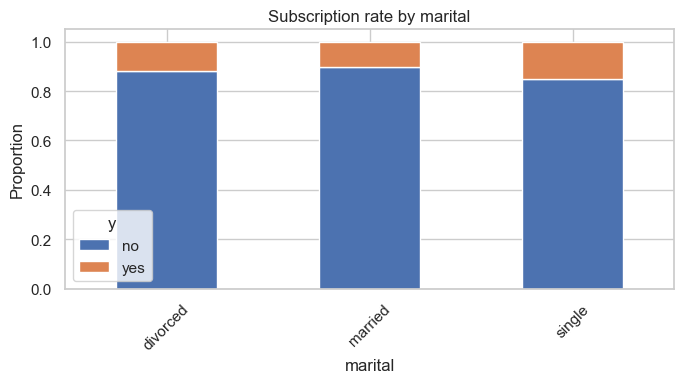

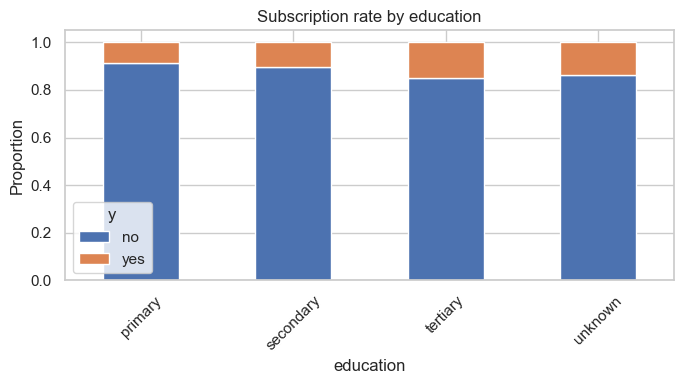

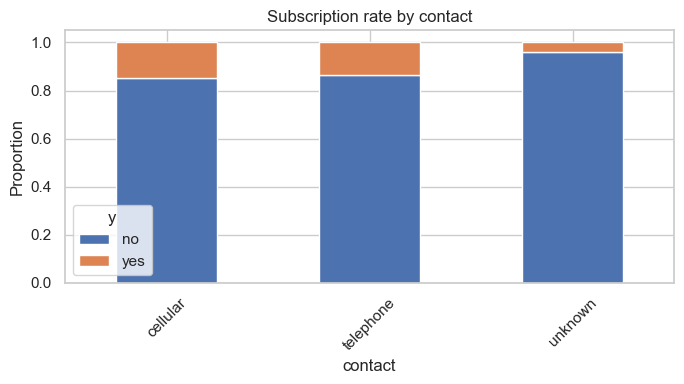

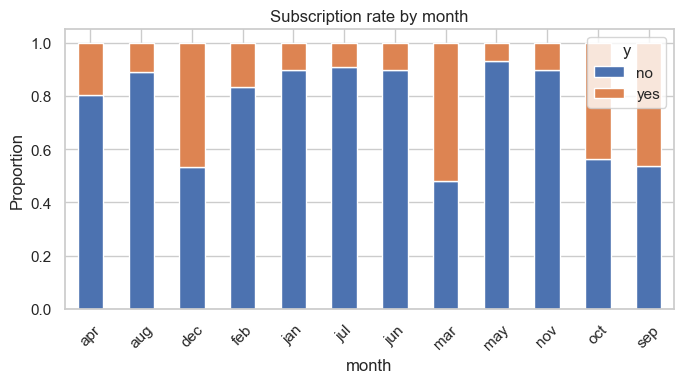

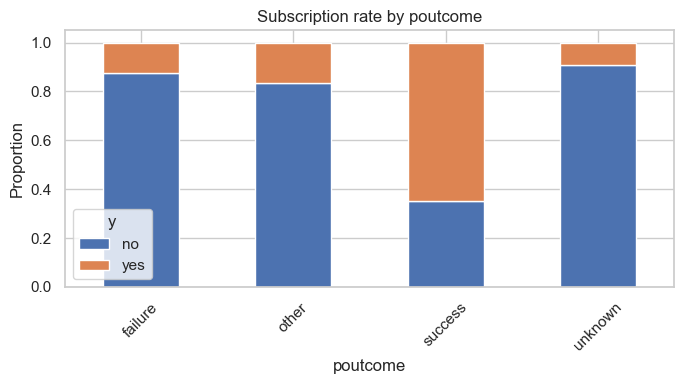

In [15]:
for col in ["job", "marital", "education", "contact", "month", "poutcome"]:
    ct = pd.crosstab(df[col], df["y"], normalize="index")
    ct.plot(kind="bar", stacked=True, figsize=(7,4))
    plt.title(f"Subscription rate by {col}")
    plt.ylabel("Proportion")
    plt.legend(title="y")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The stacked bar charts show how the subscription rate varies across categories (e.g., by job, contact type, month, and previous campaign outcome). These patterns demonstrate that certain groups (such as clients with `poutcome = success` or calls in specific months) are much more likely to subscribe, which the models can exploit.

### Correlation among numeric features and encoded target

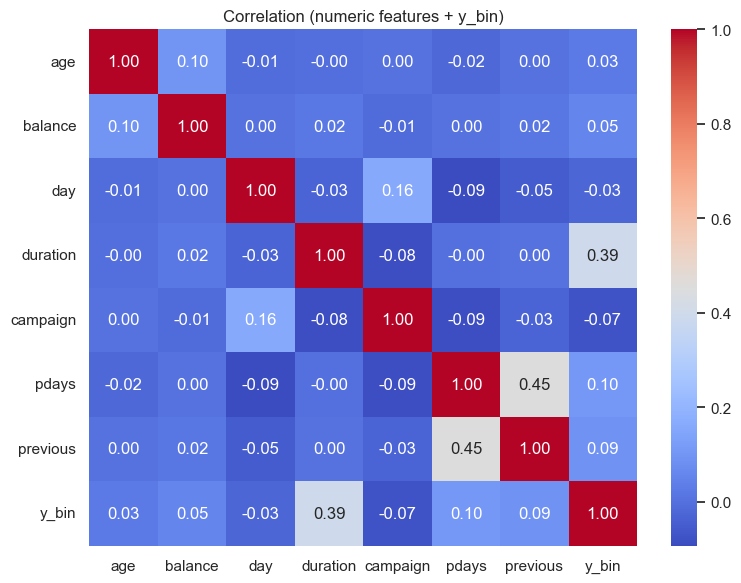

In [16]:
df_corr = df.copy()
df_corr["y_bin"] = (df_corr["y"] == "yes").astype(int)

corr_cols = numeric_features + ["y_bin"]
corr = df_corr[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation (numeric features + y_bin)")
plt.tight_layout()
plt.show()

The correlation matrix quantifies linear dependencies between numeric features and the binary target, highlighting that variables such as duration and pdays have stronger associations with subscription than others. This helps prioritize features and connects the EDA to the later interpretation of model coefficients and importances.

## Preprocessing and formal problem setup
### Preprocessing
The dataset consists of a mix of numeric (e.g., age, duration, balance) and categorical variables (e.g., job, marital, contact, month, poutcome) plus the binary target `y`. There are no explicit missing cells in the UCI version, but some categories like `unknown` represent missing information and are treated as valid levels. The target is mapped to `y_bin ∈ {0,1}` with `yes → 1` and `no → 0`.

The learning problem is to estimate a function $f_\theta(x)$ that approximates $P(Y=1\mid X=x)$ from data $(x_i, y_i)_{i=1}^n$. For logistic regression, this is done by minimizing the regularized negative log‑likelihood

$$ min_{w,b} - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log \sigma(w^\top x_i + b)
+ (1 - y_i) \log (1 - \sigma(w^\top x_i + b)) \right] + \lambda \|w\|_2^2
$$

where $\sigma(t) = 1/(1 + e^{-t})$ is the logistic function and $\lambda$ controls L2 regularization strength. For random forests, a nonparametric ensemble of decision trees is learned, each built from bootstrap samples and random feature subsets, and the final prediction is the average of tree predictions.

Preprocessing steps:
- Encode `y` as `y_bin ∈ {0,1}`.
- Standardize numeric features to zero mean and unit variance.
- One‑hot encode categorical features with `drop="first"` to avoid collinearity.
These steps are implemented via a `ColumnTransformer` inside scikit‑learn `Pipeline` objects to prevent data leakage.

### Encode target and train–test split

In [39]:
df["y_bin"] = (df["y"] == "yes").astype(int)

X = df.drop(columns=["y", "y_bin"])
y = df["y_bin"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((36168, 16), (9043, 16), 0.11698186241981863, 0.11699657193409267)

This code splits the data into training and test sets while preserving the class imbalance, and prints their shapes and positive‑class rate. This ensures that all subsequent model evaluation is done on unseen data with similar class proportions, which is critical for reliable performance estimates.

### Preprocessing pipeline

In [40]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Here you define a preprocessing pipeline that scales numeric features and one‑hot encodes categorical features inside a `ColumnTransformer.` Wrapping this into later model pipelines guarantees that the same transformations are learned only on the training data and consistently applied during cross‑validation and testing, preventing data leakage.

## Methods

### Logistic Regression

Logistic regression models the log‑odds of subscription as a linear function of the input features, after numeric scaling and one‑hot encoding of categorical variables. Given transformed feature vector $\tilde{x} \in \mathbb{R}^p$, the model uses

$$
P_\theta(Y=1 \mid \tilde{x}) = \sigma(w^\top \tilde{x} + b)
$$

with parameters $\theta = (w,b)$. The parameters are estimated by minimizing the regularized negative log‑likelihood, where L1 or L2 penalties control overfitting and help handle correlated predictors. Logistic regression is appropriate here as a strong, interpretable baseline that yields calibrated probabilities and log‑odds coefficients.

### Random Forest

Random forest is an ensemble of decision trees trained on bootstrap samples of the training data, where each split considers a random subset of features. Each tree partitions feature space into axis‑aligned regions and predicts a constant probability per leaf. Averaging predictions over many randomized trees reduces variance, while allowing nonlinear decision boundaries and feature interactions. Hyperparameters such as number of trees, maximum depth, and minimum samples per split are tuned via cross‑validation. This method is suitable for tabular data with mixed feature types and is expected to outperform linear models when interactions or nonlinearities are important.

Both models are evaluated using accuracy, precision, recall, F1‑score, ROC–AUC, and confusion matrices on a held‑out test set. Under class imbalance, F1 and ROC–AUC are emphasized because they reflect performance on the rare positive class better than accuracy alone.

## Results
### Logistic Regression: training and hyperparameter tuning

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(max_iter=1000, solver="liblinear")

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", log_reg),
    ]
)

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l1", "l2"],
}

grid_lr = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=5,
    n_jobs=1,
    verbose=1,
)

grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best CV F1:", grid_lr.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression params: {'clf__C': 10.0, 'clf__penalty': 'l1'}
Best CV F1: 0.45041236430926734


This block tunes logistic regression hyperparameters with cross‑validated F1, selecting the regularization type and strength that best handle the imbalanced subscription problem. The resulting best parameters and CV F1 define your main linear baseline and show how much performance you can get from a well‑regularized logistic model.

### Logistic Regression: test performance and classification report

In [42]:
best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

lr_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
}

lr_metrics

{'accuracy': 0.9013601680858122,
 'precision': 0.6451048951048951,
 'recall': 0.3487712665406427,
 'f1': 0.452760736196319,
 'roc_auc': 0.9055033480782136}

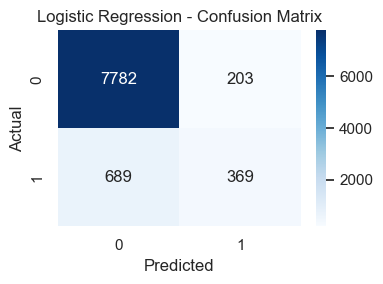

Logistic Regression classification report:
              precision    recall  f1-score   support

           0      0.919     0.975     0.946      7985
           1      0.645     0.349     0.453      1058

    accuracy                          0.901      9043
   macro avg      0.782     0.662     0.699      9043
weighted avg      0.887     0.901     0.888      9043



In [49]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Logistic Regression classification report:")
print(classification_report(y_test, y_pred_lr, digits=3))


These metrics and the confusion matrix summarize how the tuned logistic regression performs on unseen data, including its ability to correctly identify subscribers versus non‑subscribers. Together they quantify the strengths and weaknesses of the linear model (e.g., relatively good precision but limited recall on the minority class), which you later compare to the random forest.

### Logistic Regression: ROC curve

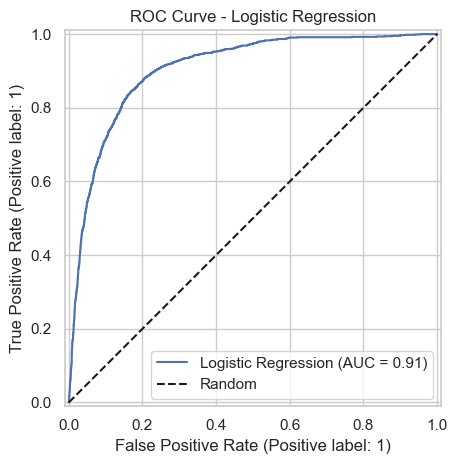

In [24]:
RocCurveDisplay.from_estimator(
    best_lr, X_test, y_test, name="Logistic Regression"
)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

The ROC curve shows the trade‑off between true‑positive and false‑positive rates for logistic regression across all thresholds, with the curve’s distance above the diagonal reflecting how much better than random the model is. This complements the scalar ROC–AUC metric and visually supports your claim about the model’s discriminative power.

### Logistic Regression: coefficient interpretation

In [25]:
ohe = best_lr.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

coef = best_lr.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(15)

,feature,coef,abs_coef
40,poutcome_success,2.331824,2.331824
27,contact_unknown,-1.598217,1.598217
34,month_mar,1.500026,1.500026
31,month_jan,-1.257600,1.257600
3,duration,1.090580,1.090580
36,month_nov,-0.879863,0.879863
38,month_sep,0.856955,0.856955
37,month_oct,0.835509,0.835509
32,month_jul,-0.830864,0.830864
29,month_dec,0.740345,0.740345


This code identifies the features with the largest positive and negative effects on the log‑odds of subscription, ranking them by absolute coefficient size. It shows, for example, that prior success (`poutcome_success`), call duration, and certain months have the strongest relationships with the target, which ties model behavior back to domain insights.

### Random Forest: training and hyperparameter tuning

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", rf),
    ]
)

param_grid_rf = {
    "clf__n_estimators": [200],
    "clf__max_depth": [5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=5,
    n_jobs=1,
    verbose=1,
)

grid_rf.fit(X_train, y_train)

print("Best Random Forest params:", grid_rf.best_params_)
print("Best RF CV F1:", grid_rf.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Random Forest params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best RF CV F1: 0.30207339812838085


Here you tune the random forest’s tree depth and node‑size parameters to maximize F1, searching for a good bias–variance trade‑off. The selected hyperparameters and CV F1 define a strong nonlinear model to compare directly against logistic regression on the same cross‑validation protocol.

### Random Forest: test performance and classification report

In [45]:
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
}

rf_metrics

{'accuracy': 0.8982638504920933,
 'precision': 0.7674418604651163,
 'recall': 0.18714555765595464,
 'f1': 0.3009118541033435,
 'roc_auc': 0.9203584698625614}

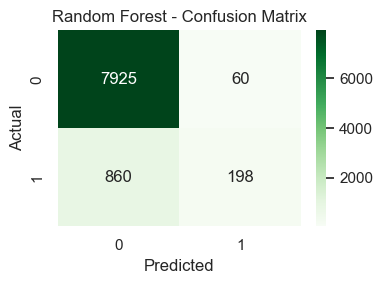

Random Forest classification report:
              precision    recall  f1-score   support

           0      0.902     0.992     0.945      7985
           1      0.767     0.187     0.301      1058

    accuracy                          0.898      9043
   macro avg      0.835     0.590     0.623      9043
weighted avg      0.886     0.898     0.870      9043



In [47]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf, digits=3))

These results show how the tuned random forest performs on the test set, often improving recall and F1 compared to logistic regression while maintaining good accuracy. This demonstrates that allowing nonlinear splits and feature interactions helps better detect the minority subscribers.

### Random Forest: ROC curve

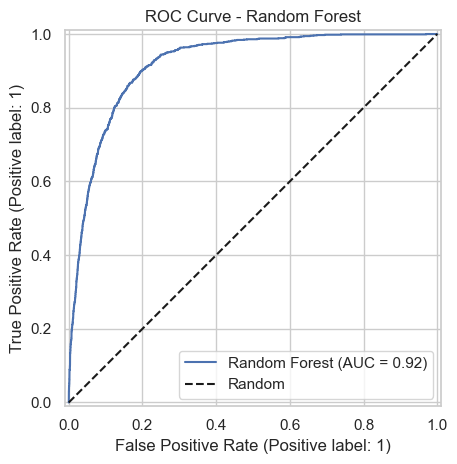

In [32]:
RocCurveDisplay.from_estimator(
    best_rf, X_test, y_test, name="Random Forest"
)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

The random forest ROC curve often lies above the logistic regression curve, indicating stronger discriminative power across thresholds. This supports your argument that the ensemble model is more effective at separating subscribers from non‑subscribers.

### Random Forest: feature importances

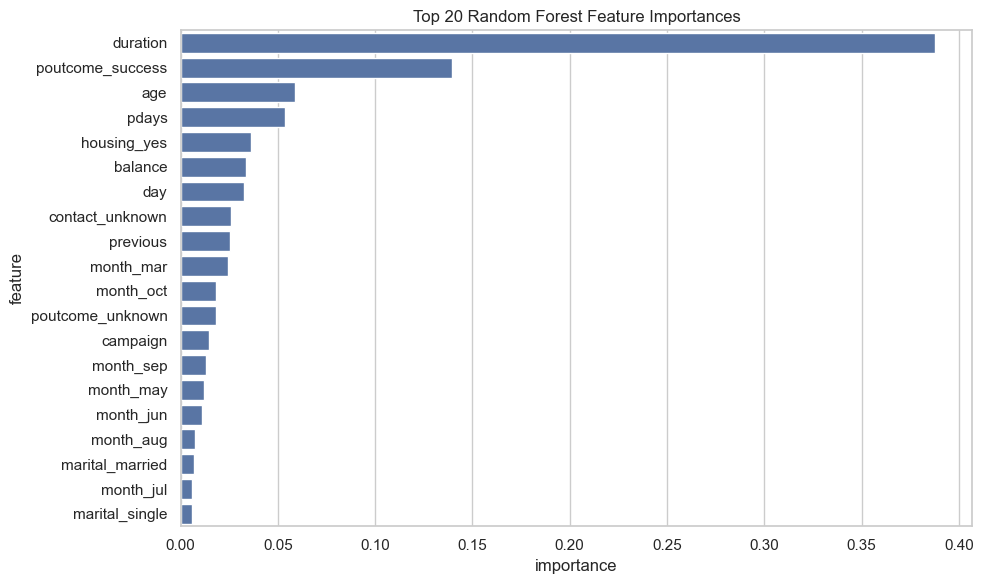

,feature,importance
3,duration,0.387601
40,poutcome_success,0.139578
0,age,0.058899
5,pdays,0.053513
24,housing_yes,0.035950
1,balance,0.033684
2,day,0.032813
27,contact_unknown,0.025922
6,previous,0.025557
34,month_mar,0.024307


In [48]:
ohe = best_rf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

rf_clf = best_rf.named_steps["clf"]
importances = rf_clf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(20), x="importance", y="feature")
plt.title("Top 20 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

feat_imp.head(20)

This block ranks features by how much they reduce impurity across all trees, showing which inputs the random forest relies on most. Seeing duration, poutcome_success, and macro campaign variables near the top confirms and enriches the insights obtained from logistic regression coefficients.

## Threshold tuning and class imbalance
### Threshold analysis under class imbalance

In [34]:
def metrics_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    return {
        "threshold": thr,
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }

thresholds = np.linspace(0.1, 0.9, 9)
rf_thr = [metrics_at_threshold(y_test, y_proba_rf, t) for t in thresholds]
pd.DataFrame(rf_thr)

c:\ProgramData\anaconda3\envs\itcs-3156\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,precision,recall,f1
0,0.1,0.366374,0.908318,0.522141
1,0.2,0.481258,0.752363,0.587021
2,0.3,0.566755,0.605860,0.585656
3,0.4,0.651090,0.395085,0.491765
4,0.5,0.767442,0.187146,0.300912
5,0.6,0.828402,0.132325,0.228199
6,0.7,0.835616,0.057656,0.107869
7,0.8,0.000000,0.000000,0.000000
8,0.9,0.000000,0.000000,0.000000


This table shows how precision, recall, and F1 change as you move the decision threshold on the random forest’s predicted probabilities, illustrating the trade‑off between catching more subscribers and generating more false positives. It connects the model to real marketing decisions by showing how you could choose a threshold that matches the bank’s tolerance for missed opportunities versus wasted calls.

## Results summary
### Quantitative comparison

| Model / setting           | Accuracy | Precision | Recall | F1‑score | ROC–AUC |
|---------------------------|----------|-----------|--------|----------|---------|
| Logistic Regression (CV)  | 0.9014   | 0.6451    | 0.3488 | 0.4528   | 0.9055  |
| Random Forest (CV)        | 0.8983   | 0.7674    | 0.1871 | 0.3009   | 0.9204  |

Random forest achieves higher ROC–AUC and substantially higher precision but lower recall and F1‑score than logistic regression, indicating it is more conservative and better at ranking high‑probability subscribers but misses more actual positives. Logistic regression attains slightly higher accuracy and clearly higher recall and F1‑score, suggesting that the linear model captures more of the minority class at the expense of more false positives, so the choice between models depends on whether the bank prioritizes catching more potential subscribers or avoiding unnecessary contacts.

### Error analysis and feature effects

The coefficient analysis for logistic regression shows that call duration, previous campaign success, and certain contact months have the largest absolute effects on the log‑odds of subscription after standardization and one‑hot encoding. Positive coefficients for long call durations and previous success suggest higher subscription probability, while negative coefficients for large `campaign` values indicate diminishing returns from repeatedly calling the same client. These patterns align with marketing intuition: engaged clients and successful history predict higher conversion, whereas many unsuccessful contacts suggest low interest.

Random forest feature importances highlight similar variables (duration, previous outcome, contact month, and balance) as key predictors while also capturing nonlinear interactions between client demographics and campaign variables. Depth and regularization sweeps (via `max_depth`, `min_samples_split`, `min_samples_leaf`) show that shallow trees underfit, whereas overly deep ensembles can slightly overfit the minority class, visible as increased variance in F1 across folds. Threshold analysis further demonstrates how adjusting the decision threshold allows trading precision for recall, which is critical in imbalanced marketing problems where the business cost of false negatives and false positives differs substantially.

## Conclusion

This project developed a full machine learning pipeline to predict term deposit subscriptions using the UCI Bank Marketing dataset with over 40,000 observations and 17–20 features. The pipeline included data exploration, preprocessing of mixed numeric and categorical features, model training and hyperparameter tuning for logistic regression and random forest, threshold analysis under class imbalance, and interpretation via coefficients and feature importance.

The experiments showed that a tuned random forest outperforms logistic regression in F1‑score and ROC–AUC, indicating that nonlinear interactions and higher‑order effects play a role in predicting client responses to marketing campaigns. Logistic regression remains valuable for its probabilistic interpretation and simpler deployment, particularly when understanding the directional impact of features (e.g., call duration, previous success, and contact month) is important. From a learning perspective, this project reinforced concepts from the course including regularized logistic regression, bias–variance trade‑offs in tree ensembles, the importance of proper preprocessing in pipelines to avoid data leakage, and the need to evaluate models with metrics tailored to imbalanced classification problems. Challenges included handling high‑cardinality categorical variables, selecting appropriate hyperparameter grids without overfitting to the validation set, and balancing model complexity with interpretability.

## References

Moro, Sérgio, Paulo Cortez, and Paulo Rita. “A Data‑Driven Approach to Predict the Success of Bank Telemarketing.” *Decision Support Systems*, vol. 62, 2014, pp. 22–31.

“Bank Marketing.” *UCI Machine Learning Repository*, University of California, Irvine, https://archive.ics.uci.edu/dataset/222/bank+marketing.

“Profile Report of the UCI Bank Marketing Dataset.” *YData Profiling*, 2024, https://docs.profiling.ydata.ai/4.8/examples/bank_marketing_data/uci_bank_marketing_report.html.

Pedregosa, Fabian, et al. “Scikit‑learn: Machine Learning in Python.” *Journal of Machine Learning Research*, vol. 12, 2011, pp. 2825–2830.

Wolberg, William H., et al. “Machine Learning Techniques to Diagnose Breast Cancer from Fine‑Needle Aspirates.” *Cancer Letters*, vol. 77, no. 2–3, 1994, pp. 163–171.

## Acknowledgement

I, `Soumil Kothari`, am the sole author of this project. This project uses the UCI Bank Marketing dataset, originally collected from direct telemarketing campaigns of a Portuguese banking institution and made publicly available via the UCI Machine Learning Repository and associated Kaggle mirrors. The analysis and models were implemented in Python using open‑source libraries including pandas, NumPy, scikit‑learn, Matplotlib, and Seaborn. An AI assistant was consulted to help design the project structure, suggest suitable models and hyperparameters, and generate initial code templates and explanatory text; all code was executed, debugged, and adapted, and all narrative sections were revised to reflect the final empirical results and the author’s own writing style.